In [21]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



## Gradient Boost Guided Example
Look at gradient boost with SKLearn.  Use European Social Survey Data, but now with a categorical outcome <br>
Outcome: Whether or not someone lives with a partner

In [3]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors
# Set our outcome to 0 and 1
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set
X_test, y_test = X[offset:], y[offset:]

In [4]:
print(X_train.head())

   year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  agea  \
0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0  60.0   
1     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0  59.0   
2     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0  24.0   
3     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   2.0  64.0   
4     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   2.0  55.0   

   CH  CZ  DE  ES  NO  SE  
0   1   0   0   0   0   0  
1   1   0   0   0   0   0  
2   1   0   0   0   0   0  
3   1   0   0   0   0   0  
4   1   0   0   0   0   0  


In [19]:
# We'll make 500 interations, use 2-deep trees, and set our loss
params = {'n_estimators':500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [6]:
print(table_train)

col_0     0.0   1.0   All
partner                  
0.0      4167   341  4508
1.0      1291  1533  2824
All      5458  1874  7332


In [20]:
clf.score(X_test, y_test)

0.7521472392638037

Get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees

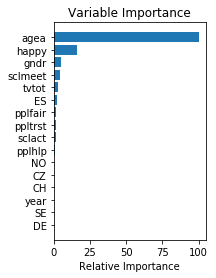

In [7]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### DRILL: Improve this gradient boost model
While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

Creating new features <br>
Applying more overfitting-prevention strategies like subsampling <br>
More iterations <br>
Trying a different loss function <br>
Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [13]:
# Use a grid search to find the best parameters
param_grid = {'n_estimators': np.arange(50, 100, 10),
          'max_depth': np.arange(1, 7, 2),
          'loss': ['deviance', 'exponential'],
          'subsample': np.arange(.6, 1.05, .1)}


# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier()

grid_clf = GridSearchCV(clf, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([50, 60, 70, 80, 90]), 'max_depth': array([1, 3, 5]), 'loss': ['deviance', 'exponential'], 'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
print(grid_clf.best_params_)

{'loss': 'exponential', 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8999999999999999}


In [41]:
print(grid_clf.best_score_)

0.7424986361156574


In [12]:
params = {'n_estimators':100,
          'max_depth': 3,
          'loss': 'exponential'}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.041734860883797055
Percent Type II errors: 0.18398799781778505

Test set accuracy:
Percent Type I errors: 0.05521472392638037
Percent Type II errors: 0.19631901840490798


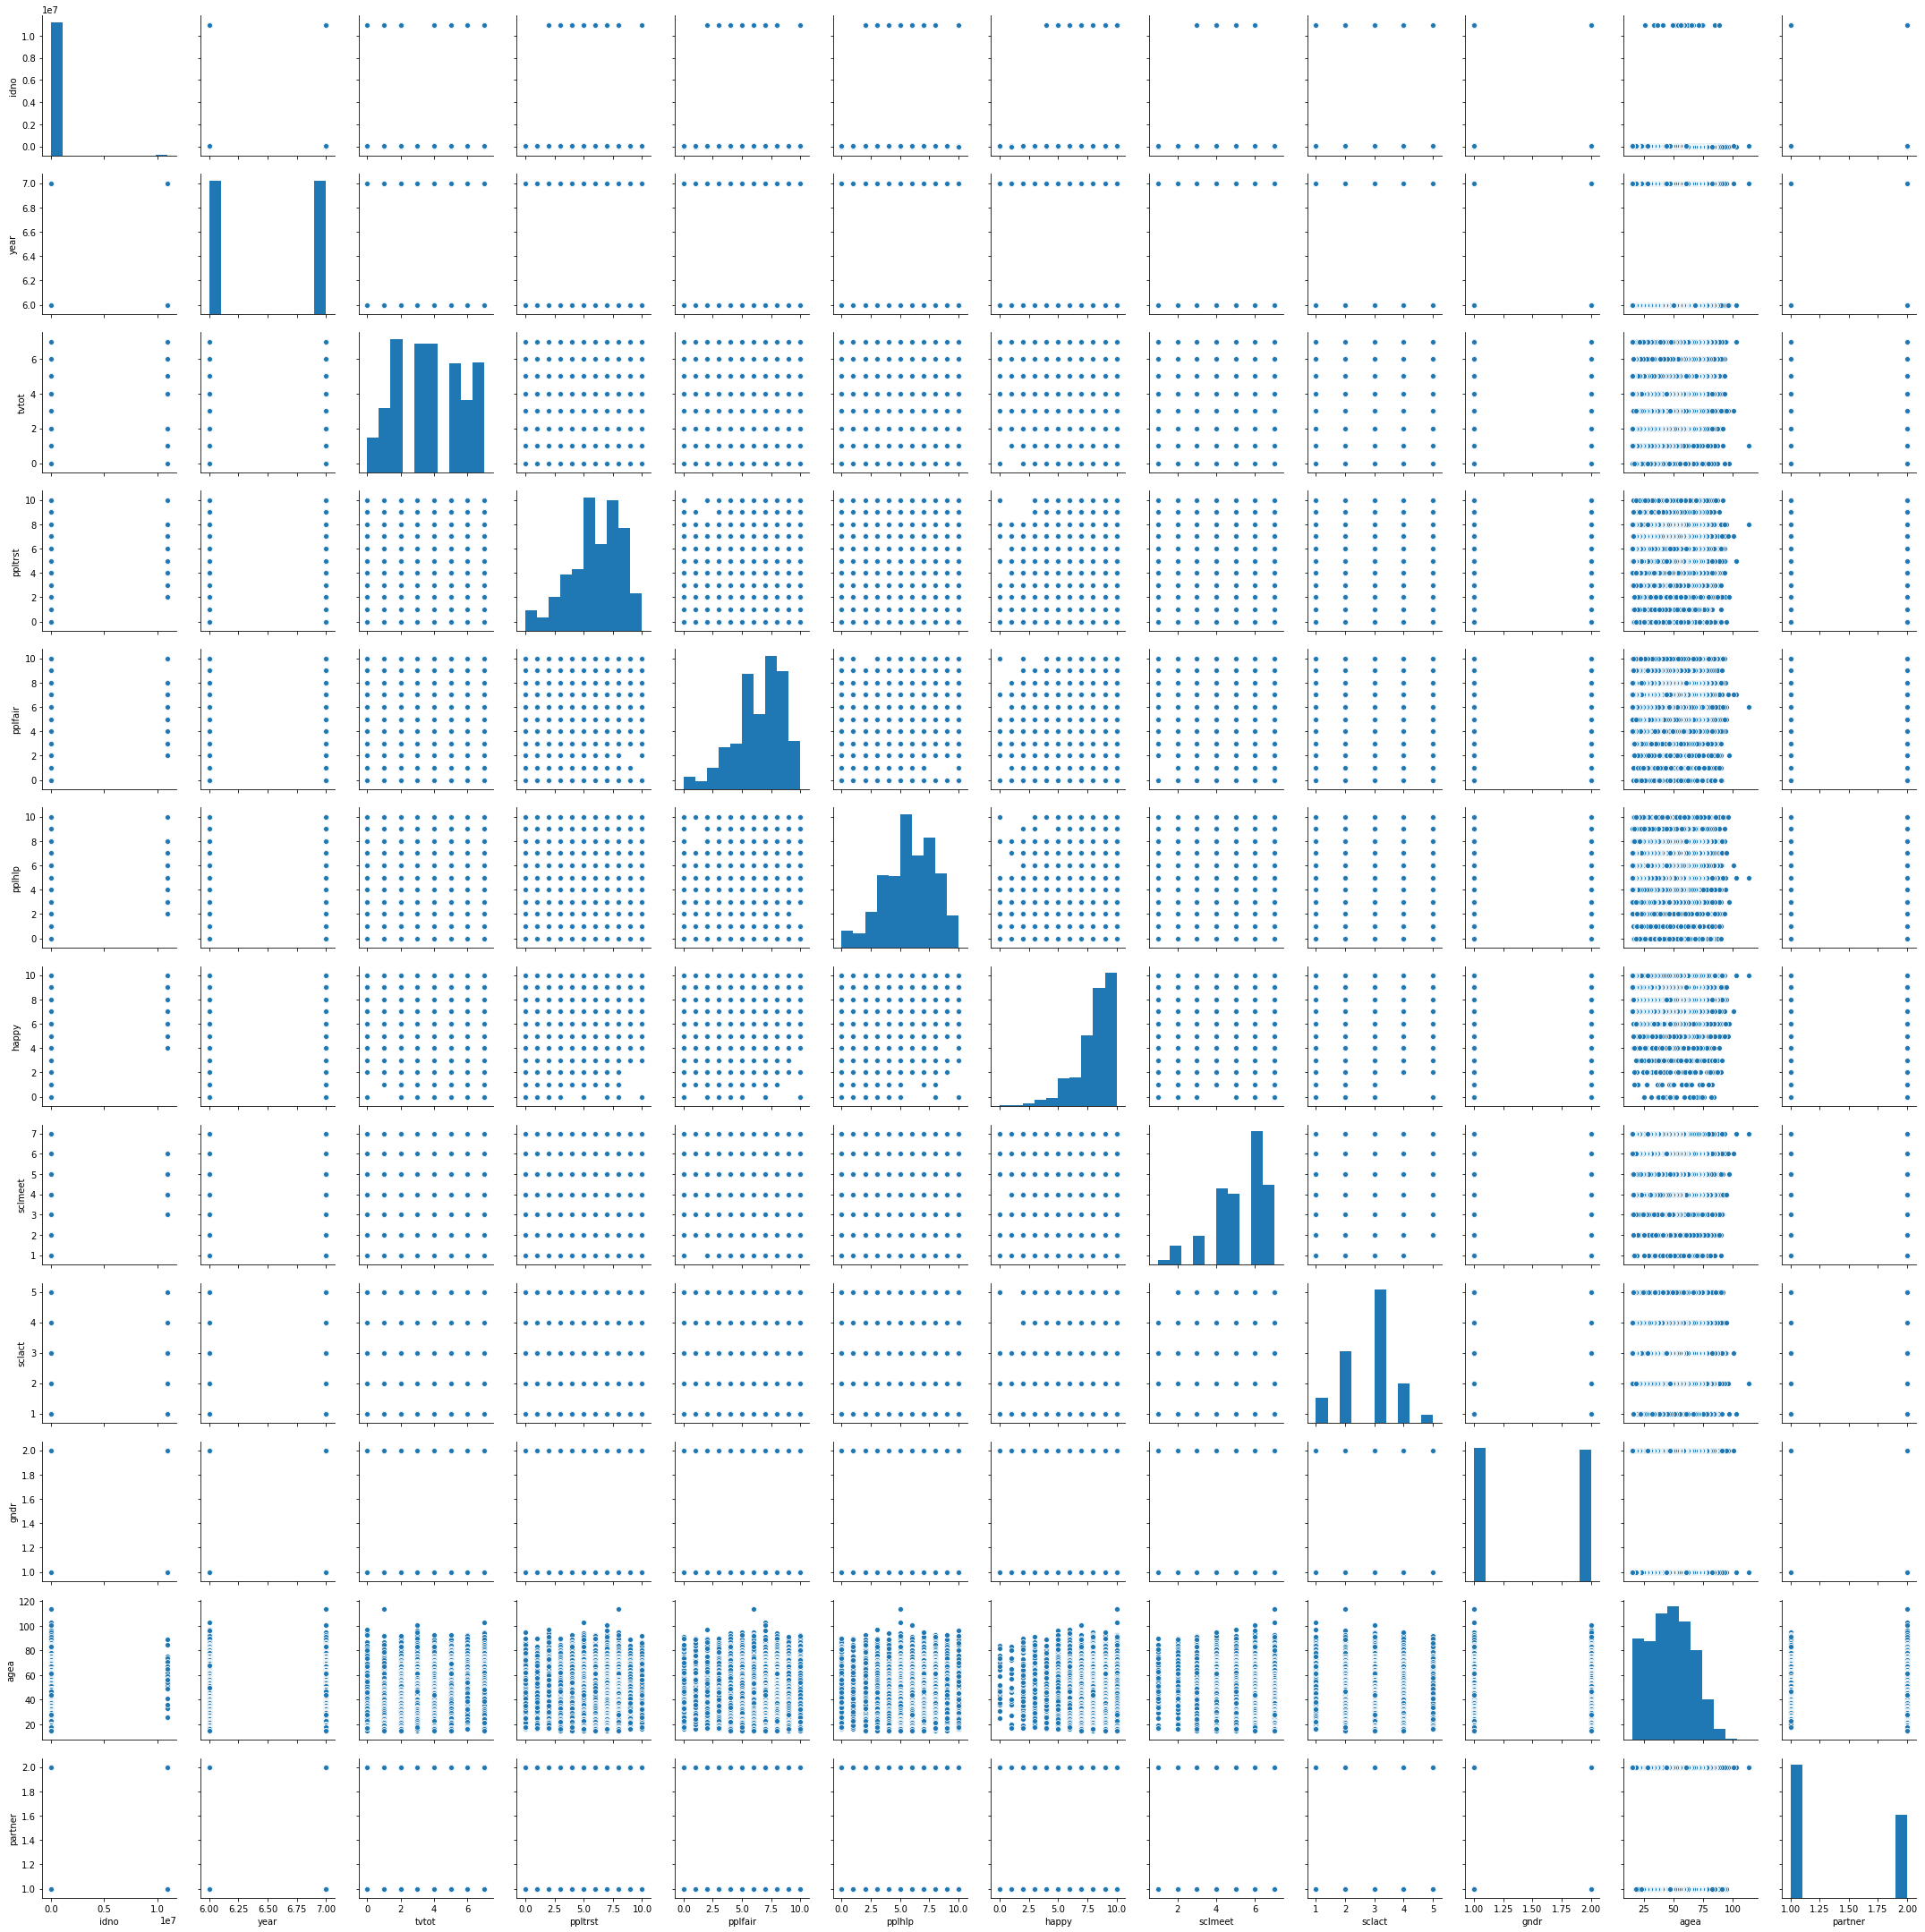

In [22]:
sns.pairplot(df)


In [23]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


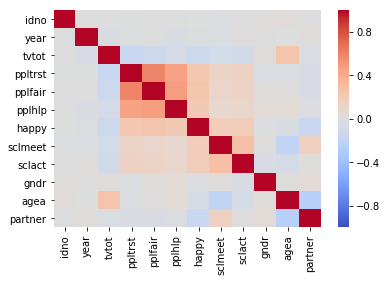

In [26]:
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1., vmax=1)

In [28]:
df.describe()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
count,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,4.022622e+04,6.500307,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,1.496379,47.262182,1.384681
std,6.320721e+05,0.500031,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,0.500018,18.316890,0.486550
min,1.000000e+00,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,1.000000
25%,1.063000e+03,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,1.000000
50%,1.749000e+03,7.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,1.000000
75%,2.778000e+03,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,2.000000
max,1.100143e+07,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,114.000000,2.000000


In [49]:
df['ppl_trst_fair_hlp'] = (df['ppltrst'] + df['pplfair'] + df['pplhlp'])/3
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,ppl_trst_fair_hlp
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,6.000000
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,5.666667
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,8.000000
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,6.333333
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,6.000000


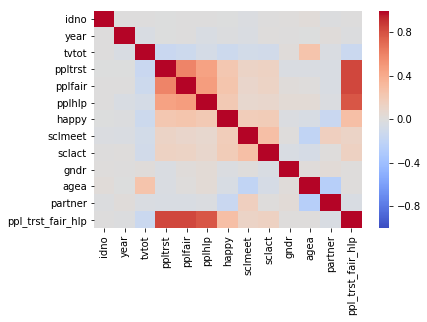

In [50]:
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1., vmax=1)

In [51]:
# Define outcome and predictors
# Set our outcome to 0 and 1
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno', 'ppltrst', 'pplfair', 'pplhlp'])]

# Make the categorical variable 'country' into dummies
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set
X_test, y_test = X[offset:], y[offset:]

In [52]:
# We'll make 500 interations, use 2-deep trees, and set our loss
params = {'n_estimators':500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.047599563557010366
Percent Type II errors: 0.17757774140752863

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.18404907975460122


In [53]:
clf.score(X_test, y_test)

0.7558282208588957

In [54]:
# Use a grid search to find the best parameters
param_grid = {'n_estimators': np.arange(50, 550, 50),
          'max_depth': np.arange(1, 5, 1),
          'loss': ['deviance', 'exponential'],
          'subsample': np.arange(.6, 1.05, .3)}


# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier()

grid_clf = GridSearchCV(clf, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]), 'max_depth': array([1, 2, 3, 4]), 'loss': ['deviance', 'exponential'], 'subsample': array([0.6, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
print(grid_clf.best_params_)

{'loss': 'exponential', 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 50, 'subsample': 1.0}


In [61]:
print(grid_clf.best_score_)

0.7532733224222586


In [62]:
param_grid = {'n_estimators': np.arange(10, 60, 10),
          'max_depth': np.arange(1, 5, 1),
          'loss': ['deviance', 'exponential'],
          'subsample': np.arange(.8, 1.05, .1),
          'min_samples_leaf': np.arange(1, 4, 1)}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier()

grid_clf = GridSearchCV(clf, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([10, 20, 30, 40, 50]), 'max_depth': array([1, 2, 3, 4]), 'loss': ['deviance', 'exponential'], 'subsample': array([0.8, 0.9, 1. ]), 'min_samples_leaf': array([1, 2, 3])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)

{'loss': 'deviance', 'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 30, 'subsample': 0.8}
0.7543644298963448


In [64]:
# We'll make 500 interations, use 2-deep trees, and set our loss
params = {'n_estimators': 30,
          'max_depth': 4,
          'loss': 'deviance',
          'subsample': 0.8,
          'min_samples_leaf': 3}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.034506273867975994
Percent Type II errors: 0.19367157665030005

Test set accuracy:
Percent Type I errors: 0.05521472392638037
Percent Type II errors: 0.20245398773006135


In [65]:
clf.score(X_test, y_test)

0.7423312883435583

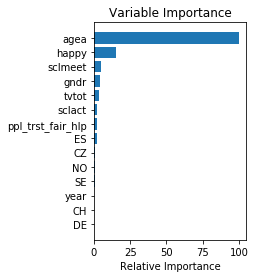

In [66]:
feature_importance = clf.feature_importances_
# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [67]:
X.head()

,year,tvtot,happy,sclmeet,sclact,gndr,agea,ppl_trst_fair_hlp,CH,CZ,DE,ES,NO,SE
0,6,3.0,8.0,5.0,4.0,2.0,60.0,6.000000,1,0,0,0,0,0
1,6,6.0,9.0,3.0,2.0,2.0,59.0,5.666667,1,0,0,0,0,0
2,6,1.0,7.0,6.0,3.0,1.0,24.0,8.000000,1,0,0,0,0,0
3,6,4.0,10.0,6.0,2.0,2.0,64.0,6.333333,1,0,0,0,0,0
4,6,5.0,8.0,7.0,2.0,2.0,55.0,6.000000,1,0,0,0,0,0


In [68]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,ppl_trst_fair_hlp
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,6.000000
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,5.666667
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,8.000000
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,6.333333
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,6.000000
